#Import Libraries

In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import os

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from functools import partial
from sklearn.ensemble import RandomForestRegressor

#Import Dataset and Getting Familiar

In [2]:
# Download dataset as a Pandas dataframe
data = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")

In [3]:
# View header of datset
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


>>🔍 **Observation**: There are both numerical, binary, categorical and geographical features in this dataset


In [4]:
# Access mmore info about each feature
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


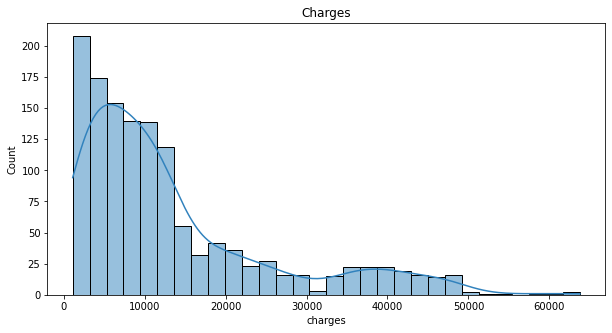

In [5]:
# View distribution of charges
plt.figure(figsize=(10, 5))
sns.histplot(data=data['charges'], kde=True, color='#3182bd')
plt.title('Charges');

In [6]:
# See if there is any missing values to fiex before starting
data.isnull().values.any()

False

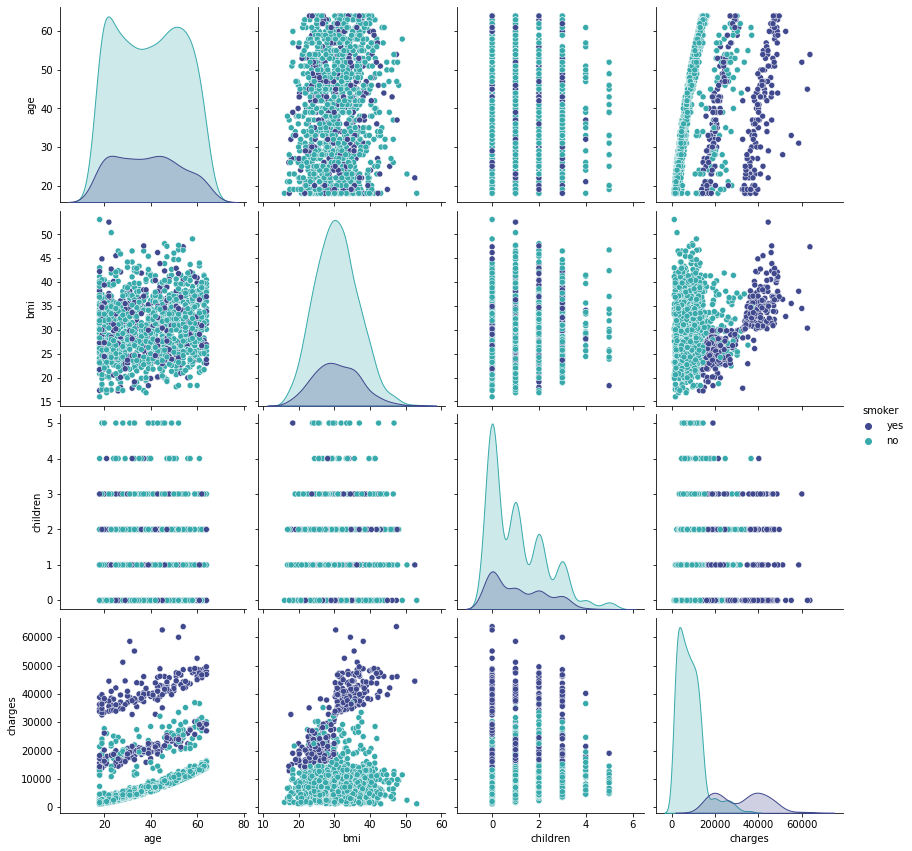

In [7]:
# View how the numerical features relate to whether someone is a smoker or not
sns.pairplot(data, hue='smoker', palette='mako', height=3.0); 

>>🔍**Observation**: Whether someone is a smoker or not seems to have a great effect on the `charges` feature, along with other features too.

In [8]:
# Before any model is created, let's create a table to store the results
def add_results(df, name, mae_valid, mae_test, mse_valid, mse_test):
  """
  Adds several passed values to a specified Pandas dataframe.
  """
  res = {'name': name,
         'mae_valid': mae_valid,
         'mae_test': mae_test,
         'mse_valid': mse_valid, 
         'mse_test': mse_test}
  df = df.append(res, ignore_index=True)
  return df

In [9]:
results = pd.DataFrame(columns=['name', 'mae_valid', 'mae_test', 'mse_valid', 'mse_test'])

# Pre-Processing Data

In [10]:
# Normalize numerical values and one-hot-encode categorical ones

# Create transformer
ct = make_column_transformer(
    (MinMaxScaler(), ['age', 'bmi', 'children']),                           # features to normalize
    (OneHotEncoder(handle_unknown='ignore'), ['sex', 'smoker', 'region'])   # features to one hot encode
)

# Split dataset into x and y
x = data.drop(['charges'], axis=1)
y = data.charges

# Divide x and y into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Divide x_train and y_train into train and validation
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Fit custom transformer to features
ct.fit(x_train)

# Transform datasets that contains features
x_train_norm = ct.transform(x_train)
x_valid_norm = ct.transform(x_valid)
x_test_norm = ct.transform(x_test)

# Model 1: Linear Model (Baseline)

Since the smoker feature has such a strong correlation with charges I will be creating two seperate linear regression models - one for smokers and another for non-smokers.

/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:592: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


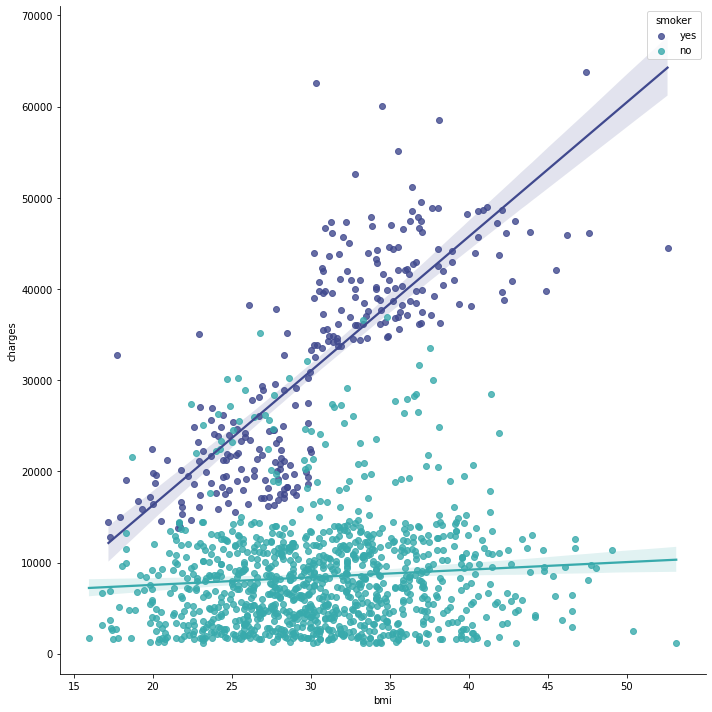

In [11]:
# Visualize what we are trying to acheive
sns.lmplot(data=data, x='bmi', y='charges', palette='mako', hue='smoker', height=10, legend_out=False);

In [12]:
# Modify the dataset for work with the linear regression model

# Isolate smoker and charges features based on if a person is a smoker or not
x_smoker_0 = np.array(data.loc[data['smoker'] == 'no'].bmi)
y_smoker_0 = np.array(data.loc[data['smoker'] == 'no'].charges)
x_smoker_1 = np.array(data.loc[data['smoker'] == 'yes'].bmi)
y_smoker_1 = np.array(data.loc[data['smoker'] == 'yes'].charges)

# Split new datasets into train and test
x_train_smoker_0, x_test_smoker_0, y_train_smoker_0, y_test_smoker_0 = train_test_split(x_smoker_0, y_smoker_0, test_size=0.2, random_state=42)
x_train_smoker_1, x_test_smoker_1, y_train_smoker_1, y_test_smoker_1 = train_test_split(x_smoker_1, y_smoker_1, test_size=0.2, random_state=42)

# Set correct shape
x_train_smoker_0 = x_train_smoker_0[:, None]
x_train_smoker_1 = x_train_smoker_1[:, None]
x_test_smoker_0 = x_test_smoker_0[:, None]
x_test_smoker_1 = x_test_smoker_1[:, None]

In [13]:
def create_and_predict_linear_model(x_train, y_train, x_test):
  """
  Creates, fits and predicts a linear model
  """
  model = LinearRegression()
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  return y_pred

In [14]:
# Calculate metrics for 'non-smokers'
smoker_0_pred = create_and_predict_linear_model(
    x_train_smoker_0,
    y_train_smoker_0,
    x_test_smoker_0,
)
smoker_0_mae = mean_absolute_error(y_test_smoker_0, smoker_0_pred)
smoker_0_mse = mean_squared_error(y_test_smoker_0, smoker_0_pred)

# Calculate metrics for 'smokers'
smoker_1_pred = create_and_predict_linear_model(
    x_train_smoker_1,
    y_train_smoker_1,
    x_test_smoker_1,
)
smoker_1_mae = mean_absolute_error(y_test_smoker_1, smoker_1_pred)
smoker_1_mse = mean_squared_error(y_test_smoker_1, smoker_1_pred)

# Calculate overall metrics
smoker_all_pred = np.concatenate((smoker_0_pred, smoker_1_pred), axis=0)
y_smoker_all = np.concatenate((y_test_smoker_0, y_test_smoker_1), axis=0)
smoker_all_mae = mean_absolute_error(y_smoker_all, smoker_all_pred)
smoker_all_mse = mean_squared_error(y_smoker_all, smoker_all_pred)

In [15]:
# View results for the linear regression model
linear_model_results = pd.DataFrame({
    'Non-smokers': [smoker_0_mae, smoker_0_mse],
    'Smokers': [smoker_1_mae, smoker_1_mse],
    'Overall': [smoker_all_mae, smoker_all_mse]},
    index=['MAE', 'MSE'])
linear_model_results.round(0)

,Non-smokers,Smokers,Overall
MAE,4510.0,5979.0,4811.0
MSE,35232666.0,65877588.0,41521736.0


In [16]:
# Add to dataframe for later compariosn with other models
results = add_results(
    df=results,
    name='linear_model',
    mae_valid=smoker_all_mae,
    mae_test=smoker_all_mae,
    mse_valid=smoker_all_mse,
    mse_test=smoker_all_mse)
results.round(2)

,name,mae_valid,mae_test,mse_valid,mse_test
0,linear_model,4811.5,4811.5,41521736.0,41521736.0


# Model 2: Random Forest Regression

In [17]:
# Create Random Forest Regressor
forest = RandomForestRegressor(
    bootstrap=False,
    n_estimators=500, 
    criterion='mae',
    random_state=1, 
    n_jobs=-1,
    verbose=0)

# Fit model
forest.fit(x_train_norm, y_train)

# Make predictions
forest_results = pd.DataFrame(columns=['type', 'mae', 'mse'])
sets = [['training', x_train_norm, y_train],
        ['validation', x_valid_norm, y_valid],
        ['testing', x_test_norm, y_test]]

# View results of the predictions
for s in sets:
  t = s[0]
  x = s[1]
  y = s[2]
  y_pred = forest.predict(x)
  mae = mean_absolute_error(y, y_pred)
  mse = mean_squared_error(y, y_pred)
  forest_results = forest_results.append({
      'type': t,
      'mae': mae,
      'mse': mse}, ignore_index=True)

forest_results.round(0)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


,type,mae,mse
0,training,15.0,91285.0
1,validation,2828.0,38553721.0
2,testing,2535.0,29772807.0


In [18]:
# Add results to Pandas dataframe for later comparison
results = add_results(
    df=results,
    name='random_forest_model',
    mae_valid=forest_results.at[1, 'mae'],
    mae_test=forest_results.at[2, 'mae'],
    mse_valid=forest_results.at[1, 'mse'],
    mse_test=forest_results.at[2, 'mse'])
results.round(2)

,name,mae_valid,mae_test,mse_valid,mse_test
0,linear_model,4811.50,4811.50,41521736.0,41521736.00
1,random_forest_model,2827.67,2534.83,38553721.1,29772806.67


# Model 3: Deep Neural Network (DNN)

In [19]:
# Add learning rate scheduler
def exponential_decay(lr0, s):
  """Set function for exponential decay learning rate scheduler"""
  def exponential_decay_fn(epoch):
    return lr0 * 0.1 ** (epoch / s)
  return exponential_decay_fn

In [20]:
# Global parameters
N_LAYERS = 5
N_NEURONS = 300
EPOCHS = 1000

# Set TensorFlow seed
tf.random.set_seed(42)

# Define custom dense layer
DenseLayer = partial(
    tf.keras.layers.Dense,
    activation='elu', 
    kernel_initializer='he_normal',
    kernel_constraint=tf.keras.constraints.max_norm(1.))

# Initialize model
DNN_model = tf.keras.Sequential()

# Add n number of hidden dense layers
for layer in range(N_LAYERS):
  DNN_model.add(DenseLayer(N_NEURONS))
  DNN_model.add(tf.keras.layers.Dropout(rate=0.2))

# Add output layer
DNN_model.add(tf.keras.layers.Dense(1))

# Compile model
DNN_model.compile(
    loss=tf.keras.losses.mae,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['mae', 'mse'])

# Add callbacks
cb = []
cb.append(tf.keras.callbacks.EarlyStopping(monitor='val_mae', min_delta=100, patience=50))
cb.append(tf.keras.callbacks.LearningRateScheduler(exponential_decay(lr0=0.008, s=50)))

# Fit model
DNN_history = DNN_model.fit(
    x_train_norm, y_train,
    validation_data=(x_valid_norm, y_valid),
    callbacks=cb,
    epochs=EPOCHS,
    verbose=0)

# Evaluate model
valid_res = DNN_model.evaluate(x_valid_norm, y_valid)
test_res = DNN_model.evaluate(x_test_norm, y_test)

9/9 [==============================] - 0s 3ms/step - loss: 1647.8154 - mae: 1647.8154 - mse: 19433892.0000


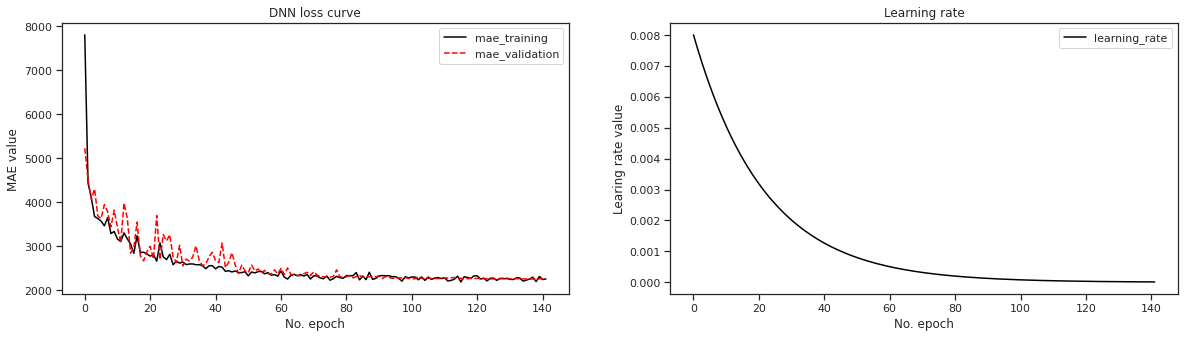

In [21]:
# Plot loss curve and learning rate

# Initialize plot
sns.set(palette='Set2', style='ticks')
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(20)
plt.ticklabel_format(useOffset=False)

# Plot loss curve
ax1.plot(
    DNN_history.history['mae'], 
    label='mae_training',
    color='black')
ax1.plot(
    DNN_history.history['val_mae'],
    label='mae_validation',
    linestyle='dashed',
    color='red')
ax1.set_xlabel('No. epoch')
ax1.set_ylabel('MAE value')
ax1.set_title('DNN loss curve')
ax1.legend(loc='upper right')

# Plot learning rate
ax2.plot(
    DNN_history.history['lr'],
    label='learning_rate',
    color='black')
ax2.set_xlabel('No. epoch')
ax2.set_ylabel('Learing rate value')
ax2.set_title('Learning rate')
ax2.legend(loc='upper right')

plt.show()

In [22]:
# Add prediction results to Pandas dataframe for later comparison
results = add_results(
    df=results,
    name='DNN_model',
    mae_valid=valid_res[1],
    mae_test=test_res[1],
    mse_valid=valid_res[2],
    mse_test=test_res[2])
results.round(2)

,name,mae_valid,mae_test,mse_valid,mse_test
0,linear_model,4811.50,4811.50,41521736.0,41521736.00
1,random_forest_model,2827.67,2534.83,38553721.1,29772806.67
2,DNN_model,2253.39,1647.82,30647194.0,19433892.00


# Multi variable regression analysis

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [24]:
X = data.drop(['charges'], axis=1)
y = data.charges

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [25]:
X

,age,sex,bmi,children,smoker,region
0,19,female,27.900,0,yes,southwest
1,18,male,33.770,1,no,southeast
2,28,male,33.000,3,no,southeast
3,33,male,22.705,0,no,northwest
4,32,male,28.880,0,no,northwest
...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest
1334,18,female,31.920,0,no,northeast
1335,18,female,36.850,0,no,southeast
1336,21,female,25.800,0,no,southwest


In [26]:
def ChangeDim(arr1D):
  arr2D = [[val] for val in arr1D]
  return arr2D

onehotencode_labels = ['sex', 'smoker', 'region']
onehotencode_data = [ChangeDim(X[label]) for label in onehotencode_labels]
X_ = X.drop(onehotencode_labels, axis=1)

for i, label in enumerate(onehotencode_labels):
  print(f'\nProcessing {label}:')
  enc = OneHotEncoder()
  enc.fit(onehotencode_data[i])
  transformed_data = enc.transform(onehotencode_data[i]).toarray()
  print(f'Detected labels are {enc.categories_[0]}')
  for i, encoded_label in enumerate(enc.categories_[0]):
    s = str(label) + '_' + str(encoded_label)
    X_[s] = transformed_data[:,i]



Processing sex:
Detected labels are ['female' 'male']

Processing smoker:
Detected labels are ['no' 'yes']

Processing region:
Detected labels are ['northeast' 'northwest' 'southeast' 'southwest']


In [27]:
X

,age,sex,bmi,children,smoker,region
0,19,female,27.900,0,yes,southwest
1,18,male,33.770,1,no,southeast
2,28,male,33.000,3,no,southeast
3,33,male,22.705,0,no,northwest
4,32,male,28.880,0,no,northwest
...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest
1334,18,female,31.920,0,no,northeast
1335,18,female,36.850,0,no,southeast
1336,21,female,25.800,0,no,southwest


In [28]:
X_

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,18,33.770,1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,28,33.000,3,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,33,22.705,0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,32,28.880,0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1334,18,31.920,0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1335,18,36.850,0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1336,21,25.800,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [29]:
# Split into training, test and validation sets. This is not neccesary for
# multi variable regression, but we want to compare results to that of other 
# models we have created

x_train, x_test, y_train, y_test = train_test_split(X_, y, test_size=0.2, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [30]:
x_train

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
94,64,31.300,2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
814,36,34.430,2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
246,60,38.060,0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
794,39,31.920,2,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1239,25,42.130,1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
953,44,30.200,2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
450,39,29.600,4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
83,48,41.230,4,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
747,19,21.755,0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [31]:
reg = LinearRegression().fit(x_train, y_train)

In [32]:
reg.score(x_valid, y_valid)

0.7268029806501222

In [33]:
reg.coef_

array([   253.20325257,    346.37664831,    363.27241561,     97.73476099,
          -97.73476099, -11774.68392578,  11774.68392578,    414.03728836,
          125.53677359,   -238.79254164,   -300.78152031])

In [34]:
reg.intercept_

-862.2214350110371

In [35]:
y_pred_valid = reg.predict(x_valid)
y_pred_test = reg.predict(x_test)

In [36]:
results = add_results(
    df=results,
    name='Multiple regression model',
    mae_valid=mean_absolute_error(y_valid, y_pred_valid),
    mae_test=mean_absolute_error(y_test, y_pred_test),
    mse_valid=0,
    mse_test=0)
results.round(2)

,name,mae_valid,mae_test,mse_valid,mse_test
0,linear_model,4811.50,4811.50,41521736.0,41521736.00
1,random_forest_model,2827.67,2534.83,38553721.1,29772806.67
2,DNN_model,2253.39,1647.82,30647194.0,19433892.00
3,Multiple regression model,4486.48,4154.40,0.0,0.00


# Summary

In [38]:
# View comparison of models metrics
results.round(0)

,name,mae_valid,mae_test,mse_valid,mse_test
0,linear_model,4811.0,4811.0,41521736.0,41521736.0
1,random_forest_model,2828.0,2535.0,38553721.0,29772807.0
2,DNN_model,2253.0,1648.0,30647194.0,19433892.0
3,Multiple regression model,4486.0,4154.0,0.0,0.0


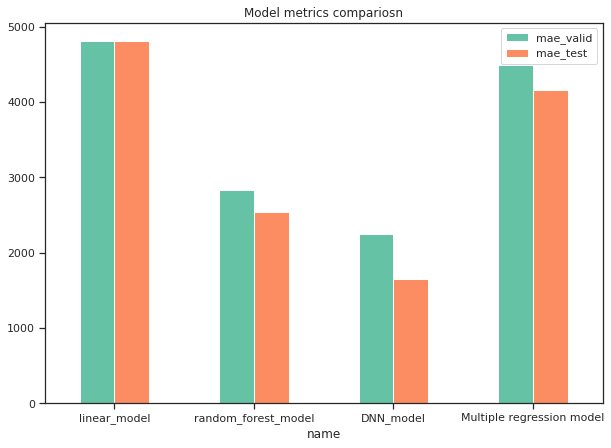

In [39]:
# Visualize the values
results.plot.bar(x='name', rot=0, y=['mae_valid', 'mae_test'], figsize=(10, 7), 
                 title='Model metrics compariosn');

>>🌟 **Conclusion**: The deep neural network model is a clear winner when it comes to predicting the charges of customers based on the provided customer features. In fact, it's scores a over twice as good compared to the linear regression model. The DNN model is not only better at making accurate predictions, but also generalizing, as its MSE values are significantly lower than the other models.